In [345]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os import listdir
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data import get_tokenizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from datetime import datetime
import re

torch.manual_seed(1)

In [346]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 16

# Model parameters
EPOCHS = 10  # Epochs
BATCH_SIZE = 64  # Batch size  // Not used yet

#Optimizer parameters
LR = 1e-3  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-8  # L2 Regularization


SHALLOW_HIDDEN_SIZE = 32
MIDDLE_HIDDEN_SIZE = 48
DEEP_HIDDEN_SIZE = 64

In [347]:
# From Week14 Solutions

# tokenizer will split a long text into a list of english words
tokenizer = get_tokenizer('basic_english')

def read_files(datapath='../dataset/data_train'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory
    files = listdir(datapath)
    files = [datapath + "/" + f for f in files if f.endswith(".txt")]

    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

books_train = read_files()
books_val = read_files('../dataset/data_val')
books_test = read_files('../dataset/data_test')

# Match any word containing digit
no_digits = '\w*[0-9]+\w*'
# Match word containing a uppercase
no_names = '\w*[A-Z]+\w*'
# Match any sequence containing more than one space
no_spaces = '\s+'

def tokenize(lines):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    for line in lines:
        line = re.sub(no_digits + "|" + no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(data, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    """
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in data:
        freqs[vocab[w]] += 1
    return freqs

# List of words contained in the dataset
list_words_train = tokenize(books_train)
list_words_val = tokenize(books_val)
list_words_test = tokenize(books_test)

# vocab contains the vocabulary found in the data, associating an index to each word
vocab = build_vocab_from_iterator(yield_tokens(books_train), min_freq=100, specials=["<unk>"])

# Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
vocab.append_token("i")

# Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
vocab.set_default_index(vocab["<unk>"])
vocab_size = len(vocab)


print("Total number of words in the training dataset:", len(list_words_train))
print("Number of distinct words in the training dataset:", len(set(list_words_train)))
print("Number of distinct words kept in the training dataset:", vocab_size)

Total number of words in the training dataset: 1368807
Number of distinct words in the training dataset: 30374
Number of distinct words kept in the training dataset: 1050


In [348]:
index2word = {}

for i in range(len(vocab)):
    index2word[i] = vocab.lookup_token(i)

In [349]:
# From Week14 solutions

def create_dataset(
    text, vocab, context_size=CONTEXT_SIZE,
):
    contexts = []
    targets = []
    n_text = len(text)

    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    for i in range(n_text - context_size):

        # true label = 'is the next word a known word (i.e. not '<unk>' token)?'
        if txt[i + context_size] == 0:
            continue

        t = txt[i+context_size]

        # Context before
        c = txt[i:i + context_size]

        targets.append(t)
        # Normally we should use word embedding, and not hot encoding, but we
        # skip that part for this exercise
        contexts.append(torch.tensor(c))

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

# data_train = create_dataset(list_words_train, vocab)
# data_val = create_dataset(list_words_val, vocab)
# data_test = create_dataset(list_words_test, vocab)

In [350]:
train_loader = torch.load('../saved_sets/train.pkl')
val_loader = torch.load('../saved_sets/val.pkl')
test_loader = torch.load('../saved_sets/test.pkl')
# train_loader = DataLoader(data_train, batch_size=64, shuffle=False)
# val_loader = DataLoader(data_val, batch_size=64, shuffle=False)
# test_loader = DataLoader(data_test, batch_size=64, shuffle=False)

In [351]:
# torch.save(train_loader, '../saved_sets/train.pkl')
# torch.save(val_loader, '../saved_sets/val.pkl')
# torch.save(test_loader, '../saved_sets/test.pkl')

In [352]:
device = torch.device('cpu')

def train(n_epochs, optimizer, model, loss_fn, train_loader):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    model.train()
    losses_train = []
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, labels in train_loader:

            # We use torch.double to get the same results as Pytorch
            #contexts = torch.permute(contexts, (1,0,2))
            contexts = contexts.to(device=device, dtype=torch.long)
            labels = labels.to(device=device, dtype=torch.long)

            outputs = model(contexts).squeeze()

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

In [353]:
class NGramModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        super(NGramModel1, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear4 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = torch.flatten(embeds, 1)
        out = F.relu(self.linear1(embeds))
        out = self.linear4(out)
        return out

In [354]:
class NGramModel2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        super(NGramModel2, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear4 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = torch.flatten(embeds, 1)
        out = F.relu(self.linear1(embeds))
        out = self.linear4(out)
        return out

In [355]:
class NGramModel3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        super(NGramModel3, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear4 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = torch.flatten(embeds, 1)
        out = F.relu(self.linear1(embeds))
        out = self.linear4(out)
        return out

In [356]:
models, model_names, losses = [], [], []

In [357]:
loss_function = nn.CrossEntropyLoss()
model1 = NGramModel1(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE, DEEP_HIDDEN_SIZE)
optimizer = optim.RAdam(model1.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
loss = train(
    EPOCHS,
    optimizer,
    model1,
    loss_function,
    train_loader
)

models.append(model1)
model_names.append("DEEP MODEL")
losses.append(loss)

16:39:13.969373  |  Epoch 1  |  Training loss 4.37023
16:40:05.712742  |  Epoch 2  |  Training loss 4.07252
16:41:03.217113  |  Epoch 3  |  Training loss 4.02626
16:42:08.325081  |  Epoch 4  |  Training loss 4.00679
16:43:09.693991  |  Epoch 5  |  Training loss 3.99610
16:44:10.640911  |  Epoch 6  |  Training loss 3.98999
16:45:16.294798  |  Epoch 7  |  Training loss 3.98666
16:46:01.873991  |  Epoch 8  |  Training loss 3.98417
16:46:46.518388  |  Epoch 9  |  Training loss 3.98282
16:47:31.233802  |  Epoch 10  |  Training loss 3.98184


In [358]:
model2 = NGramModel2(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE, MIDDLE_HIDDEN_SIZE)
loss = train(
    EPOCHS,
    optimizer,
    model2,
    loss_function,
    train_loader
)

models.append(model2)
model_names.append("MIDDLE MODEL")
losses.append(loss)

16:47:57.972231  |  Epoch 1  |  Training loss 6.98147
16:48:23.310689  |  Epoch 2  |  Training loss 6.98147
16:48:48.806101  |  Epoch 3  |  Training loss 6.98147
16:49:14.252102  |  Epoch 4  |  Training loss 6.98147
16:49:39.617085  |  Epoch 5  |  Training loss 6.98147
16:50:04.943064  |  Epoch 6  |  Training loss 6.98147
16:50:30.265901  |  Epoch 7  |  Training loss 6.98147
16:50:54.157038  |  Epoch 8  |  Training loss 6.98147
16:51:23.251452  |  Epoch 9  |  Training loss 6.98147
16:51:52.294504  |  Epoch 10  |  Training loss 6.98147


In [359]:
loss_function = nn.CrossEntropyLoss()
model3 = NGramModel3(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE, MIDDLE_HIDDEN_SIZE)
loss = train(
    EPOCHS,
    optimizer,
    model3,
    loss_function,
    train_loader
)

models.append(model3)
model_names.append("SHALLOW MODEL")
losses.append(loss)

16:52:18.703200  |  Epoch 1  |  Training loss 7.01888
16:52:43.020917  |  Epoch 2  |  Training loss 7.01888
16:53:07.170012  |  Epoch 3  |  Training loss 7.01888
16:53:31.254519  |  Epoch 4  |  Training loss 7.01888
16:53:58.097034  |  Epoch 5  |  Training loss 7.01888
16:54:23.601251  |  Epoch 6  |  Training loss 7.01888
16:54:49.669688  |  Epoch 7  |  Training loss 7.01888
16:55:15.218048  |  Epoch 8  |  Training loss 7.01888
16:55:51.073203  |  Epoch 9  |  Training loss 7.01888
16:56:35.102713  |  Epoch 10  |  Training loss 7.01888


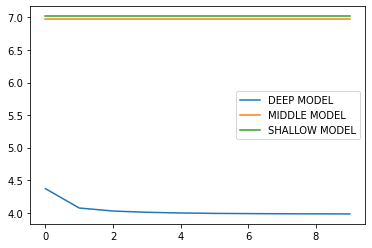

In [362]:
for i, e in zip(losses, model_names):
    plt.plot(i, label=e)
    plt.legend()
plt.show()

In [363]:
def compute_accuracy(model, loader):
    correct = 0.
    total = 0.
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += BATCH_SIZE
            correct += int((predicted == labels).sum())

    acc =  correct / total
    return acc

In [364]:
def find_best_model(loader):
    max_accuracy = 0
    best_model = 0
    for i in range(len(models)):
        model_accuracy = round(compute_accuracy(models[i], loader) * 100)

        if model_accuracy > max_accuracy:
            max_accuracy = model_accuracy
            best_model = i

    print("Best model is:", model_names[best_model])

    return models[best_model]

In [365]:
best_model = find_best_model(val_loader)

Best model is: DEEP MODEL


In [366]:
print("Test set accuracy of the best model is " + str(round(compute_accuracy(best_model, test_loader) * 100, 2)) + "%")

Test set accuracy of the best model is 18.1%


In [367]:
cos = nn.CosineSimilarity(dim=1, eps=EPSILON)
embd_weights = best_model.embeddings.weight
cosineSimilarityMatrix = [[0 for i in range(embd_weights.shape[0])] for j in range(embd_weights.shape[0])]

for i in range(embd_weights.shape[0]):
    for j in range(embd_weights.shape[0]):
        cosineSimilarityMatrix[i][j] = F.cosine_similarity(embd_weights[i], embd_weights[j], dim=0).item()


for i in range(len(cosineSimilarityMatrix)):
    for j in range(len(cosineSimilarityMatrix[0])):
        if i == 0 or j == 0:
                continue
        elif 0.8 < cosineSimilarityMatrix[i][j] < 1.0:  # Parameter '0.5' describes how equal two vectors are and should be increased with more precise embeddings
            print("\'" + index2word[i] + "\'" + " is similar to " +  "\'" + index2word[j] + "\'")

'in' is similar to 'into'
'he' is similar to 'she'
'was' is similar to 'is'
'was' is similar to 'been'
'had' is similar to 'have'
'had' is similar to 'has'
'had' is similar to 'having'
'him' is similar to 'me'
'is' is similar to 'was'
'is' is similar to 're'
'!' is similar to '?'
'?' is similar to '!'
'she' is similar to 'he'
'she' is similar to 'everyone'
'said' is similar to 'cried'
'said' is similar to 'answered'
'have' is similar to 'had'
'have' is similar to 'has'
'have' is similar to 'having'
'from' is similar to 'during'
'me' is similar to 'him'
'me' is similar to 'mine'
'by' is similar to 'beyond'
'were' is similar to 're'
'my' is similar to 'your'
'up' is similar to 'near'
'up' is similar to 'rose'
'would' is similar to 'will'
'would' is similar to 'must'
'would' is similar to 'should'
'would' is similar to 'shall'
'would' is similar to 'may'
'would' is similar to 'might'
'been' is similar to 'was'
'been' is similar to 'being'
'will' is similar to 'would'
'will' is similar to 

In [368]:

import pandas as pd
var = vocab.to()
voc_dict = var.vocab.get_stoi()
vocab_list = [x for x in voc_dict.keys()]
df = pd.DataFrame(vocab_list).to_csv('../website/vocab.tsv', header=False, index=False, sep="\t")



In [369]:
track = []
for word in range(len(vocab_list)):
    ind = torch.tensor(word, dtype=torch.int).cpu()
    emb = best_model.embeddings(ind)
    track.append(emb.tolist())
df2 = pd.DataFrame(track).to_csv('../website/embedd.tsv', header=False, index=False, sep="\t")

2.2

In [370]:
conjugations = ['am', 'are', 'is', 'has', 'were', 'was', 'being', 'been','be', 'have', 'had', 'having']

conj_vocab = {}
for i in range(len(conjugations)):
    conj_vocab[vocab[conjugations[i]]] = i

def create_dataset_between(
    text, vocab, context_size=2,
):
    contexts = []
    targets = []
    n_text = len(text)

    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    for i in range(1, n_text - context_size - 1):

        # true label = 'is the next word a known word (i.e. not '<unk>' token)?'
        if txt[i] == 0 or index2word[txt[i]] not in conjugations:
            continue

        t = conj_vocab[txt[i]]

        # Context before
        c = [txt[i - 1]] + [txt[i + 1]]

        targets.append(t)
        # Normally we should use word embedding, and not hot encoding, but we
        # skip that part for this exercise
        contexts.append(torch.tensor(c))

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

data_train_between = create_dataset_between(list_words_train, vocab)
data_val_between = create_dataset_between(list_words_val, vocab)
data_test_between = create_dataset_between(list_words_test, vocab)

In [371]:
train_loader_between = DataLoader(data_train_between, batch_size=64, shuffle=False)
val_loader_between = DataLoader(data_val_between, batch_size=64, shuffle=False)
test_loader_between = DataLoader(data_test_between, batch_size=64, shuffle=False)

In [372]:
class MLP1(nn.Module):
  def __init__(self, embedding_dim, context_size, num_classes, hidden_size):
    super(MLP1, self).__init__()
    #self.embeddings = nn.Embedding.from_pretrained(best_model.embeddings, freeze=True)
    self.embeddings = best_model.embeddings
    self.linear = nn.Linear(context_size * embedding_dim, hidden_size)
    self.output = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    embeds = self.embeddings(x)
    embeds = torch.flatten(embeds, 1)
    out = F.relu(self.linear(embeds))
    out = self.output(out)
    return out

In [373]:
class RNN1(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN1, self).__init__()
        #self.embeddings = nn.Embedding.from_pretrained(best_model.embeddings, freeze=True)
        self.embeddings = best_model.embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [374]:
class MLP2(nn.Module):
  def __init__(self, embedding_dim, context_size, num_classes, hidden_size):
    super(MLP2, self).__init__()
    #self.embeddings = nn.Embedding.from_pretrained(best_model.embeddings, freeze=True)
    self.embeddings = best_model.embeddings
    self.linear = nn.Linear(context_size * embedding_dim, hidden_size)
    self.output = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    embeds = self.embeddings(x)
    embeds = torch.flatten(embeds, 1)
    out = F.relu(self.linear(embeds))
    out = self.output(out)
    return out

In [375]:
class RNN2(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN2, self).__init__()
        #self.embeddings = nn.Embedding.from_pretrained(best_model.embeddings, freeze=True)
        self.embeddings = best_model.embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [376]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 16

# Model parameters
EPOCHS = 20  # Epochs
BATCH_SIZE = 64  # Batch size  // Not used yet

#Optimizer parameters
LR = 1e-3  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-8  # L2 Regularization

SHALLOW_HIDDEN_SIZE = 32
DEEP_HIDDEN_SIZE = 64

NUMBER_OF_LAYERS = 2

models, model_names, losses_train, time_mlp, time_rnn = [], [], [], [], []

In [377]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model1.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)

model1 = MLP1(EMBEDDING_DIM, CONTEXT_SIZE, len(conjugations), DEEP_HIDDEN_SIZE)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model1,
    loss_function,
    train_loader_between
)
time_mlp.append(time.time() - star_time)
models.append(model1)
model_names.append("Deep MLP")
losses_train.append(loss)

16:58:39.484096  |  Epoch 1  |  Training loss 2.46497
16:58:40.461222  |  Epoch 2  |  Training loss 2.38932
16:58:41.437378  |  Epoch 3  |  Training loss 2.29884
16:58:42.421572  |  Epoch 4  |  Training loss 2.21288
16:58:43.400904  |  Epoch 5  |  Training loss 2.13572
16:58:44.377759  |  Epoch 6  |  Training loss 2.06914
16:58:45.375729  |  Epoch 7  |  Training loss 2.01243
16:58:46.415136  |  Epoch 8  |  Training loss 1.96353
16:58:47.390805  |  Epoch 9  |  Training loss 1.92082
16:58:48.365745  |  Epoch 10  |  Training loss 1.88338
16:58:49.345277  |  Epoch 11  |  Training loss 1.84999
16:58:50.311323  |  Epoch 12  |  Training loss 1.82015
16:58:51.288008  |  Epoch 13  |  Training loss 1.79366
16:58:52.254573  |  Epoch 14  |  Training loss 1.76970
16:58:53.224603  |  Epoch 15  |  Training loss 1.74798
16:58:54.195328  |  Epoch 16  |  Training loss 1.72831
16:58:55.149470  |  Epoch 17  |  Training loss 1.71022
16:58:56.078621  |  Epoch 18  |  Training loss 1.69346
16:58:57.800564  | 

In [378]:
model2 = RNN1(EMBEDDING_DIM, len(conjugations), DEEP_HIDDEN_SIZE, NUMBER_OF_LAYERS)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model2,
    loss_function,
    train_loader_between
)
time_rnn.append(time.time() - star_time)
models.append(model2)
model_names.append("Deep RNN")
losses_train.append(loss)

16:59:03.583149  |  Epoch 1  |  Training loss 2.47366
16:59:07.532782  |  Epoch 2  |  Training loss 2.47334
16:59:10.525913  |  Epoch 3  |  Training loss 2.47281
16:59:14.220926  |  Epoch 4  |  Training loss 2.47194
16:59:17.173949  |  Epoch 5  |  Training loss 2.47057
16:59:20.106495  |  Epoch 6  |  Training loss 2.46853
16:59:23.067141  |  Epoch 7  |  Training loss 2.46590
16:59:26.104211  |  Epoch 8  |  Training loss 2.46300
16:59:29.165413  |  Epoch 9  |  Training loss 2.45995
16:59:31.843816  |  Epoch 10  |  Training loss 2.45678
16:59:34.481997  |  Epoch 11  |  Training loss 2.45352
16:59:37.159384  |  Epoch 12  |  Training loss 2.45013
16:59:39.798970  |  Epoch 13  |  Training loss 2.44693
16:59:42.509227  |  Epoch 14  |  Training loss 2.44388
16:59:45.173609  |  Epoch 15  |  Training loss 2.44102
16:59:47.830130  |  Epoch 16  |  Training loss 2.43851
16:59:50.418374  |  Epoch 17  |  Training loss 2.43628
16:59:53.027001  |  Epoch 18  |  Training loss 2.43425
16:59:55.674141  | 

In [379]:
model3 = MLP2(EMBEDDING_DIM, CONTEXT_SIZE, len(conjugations), SHALLOW_HIDDEN_SIZE)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model3,
    loss_function,
    train_loader_between
)
time_mlp.append(time.time() - star_time)
models.append(model3)
model_names.append("SHALLOW MLP")
losses_train.append(loss)

16:59:59.210145  |  Epoch 1  |  Training loss 2.48867
17:00:00.145292  |  Epoch 2  |  Training loss 2.32599
17:00:01.086596  |  Epoch 3  |  Training loss 2.22412
17:00:02.030650  |  Epoch 4  |  Training loss 2.14368
17:00:03.328421  |  Epoch 5  |  Training loss 2.07674
17:00:04.980001  |  Epoch 6  |  Training loss 2.01869
17:00:06.100692  |  Epoch 7  |  Training loss 1.96801
17:00:07.228250  |  Epoch 8  |  Training loss 1.92371
17:00:08.374875  |  Epoch 9  |  Training loss 1.88423
17:00:09.661965  |  Epoch 10  |  Training loss 1.84839
17:00:10.799706  |  Epoch 11  |  Training loss 1.81593
17:00:12.475288  |  Epoch 12  |  Training loss 1.78693
17:00:14.383766  |  Epoch 13  |  Training loss 1.76073
17:00:16.049671  |  Epoch 14  |  Training loss 1.73655
17:00:17.268803  |  Epoch 15  |  Training loss 1.71434
17:00:18.783436  |  Epoch 16  |  Training loss 1.69393
17:00:20.146718  |  Epoch 17  |  Training loss 1.67499
17:00:21.822634  |  Epoch 18  |  Training loss 1.65712
17:00:23.320244  | 

In [380]:
model4 = RNN2(EMBEDDING_DIM, len(conjugations), SHALLOW_HIDDEN_SIZE, NUMBER_OF_LAYERS)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model4,
    loss_function,
    train_loader_between
)
time_rnn.append(time.time() - star_time)
models.append(model4)
model_names.append("SHALLOW RNN")
losses_train.append(loss)

17:00:28.006544  |  Epoch 1  |  Training loss 2.48189
17:00:31.104738  |  Epoch 2  |  Training loss 2.48131
17:00:34.019227  |  Epoch 3  |  Training loss 2.48035
17:00:37.014544  |  Epoch 4  |  Training loss 2.47881
17:00:40.044552  |  Epoch 5  |  Training loss 2.47656
17:00:43.018292  |  Epoch 6  |  Training loss 2.47376
17:00:45.902249  |  Epoch 7  |  Training loss 2.47088
17:00:48.743609  |  Epoch 8  |  Training loss 2.46821
17:00:51.122821  |  Epoch 9  |  Training loss 2.46556
17:00:53.514748  |  Epoch 10  |  Training loss 2.46265
17:00:55.955674  |  Epoch 11  |  Training loss 2.46004
17:00:58.307292  |  Epoch 12  |  Training loss 2.45741
17:01:00.481665  |  Epoch 13  |  Training loss 2.45480
17:01:02.629987  |  Epoch 14  |  Training loss 2.45262
17:01:04.827612  |  Epoch 15  |  Training loss 2.45064
17:01:07.020696  |  Epoch 16  |  Training loss 2.44884
17:01:09.471835  |  Epoch 17  |  Training loss 2.44717
17:01:12.566932  |  Epoch 18  |  Training loss 2.44557
17:01:15.440328  | 

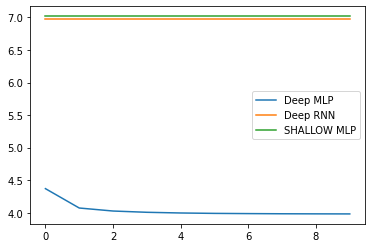

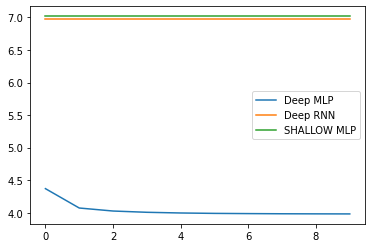

In [382]:
for i, e in zip(losses, model_names):
    plt.plot(i, label=e)
    plt.legend()
plt.show()

In [383]:
best_model = find_best_model(val_loader_between)

Best model is: SHALLOW MLP


In [384]:
print("Test set accuracy of the best model is " + str(round(compute_accuracy(best_model, test_loader_between) * 100, 2)) + "%")

Test set accuracy of the best model is 30.68%


In [385]:
avg_time_mlp = 0
avg_time_rnn = 0
for i in range(len(time_mlp)):
    avg_time_mlp += time_mlp[i]
    avg_time_rnn += time_rnn[i]

print("Avrage time training MLP:", round(avg_time_mlp / len(time_mlp), 2), "seconds vs average time training RNN", round(avg_time_rnn / len(time_rnn), 2),"seconds")

Avrage time training MLP: 23.82 seconds vs average time training RNN 56.1 seconds


2.3

In [386]:
class RNN1(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN1, self).__init__()
        #self.embeddings = nn.Embedding.from_pretrained(best_model.embeddings, freeze=True)
        self.embeddings = best_model.embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [387]:
class RNN2(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN2, self).__init__()
        #self.embeddings = nn.Embedding.from_pretrained(best_model.embeddings, freeze=True)
        self.embeddings = best_model.embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [401]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 16

# Model parameters
EPOCHS = 5  # Epochs
BATCH_SIZE = 64  # Batch size  // Not used yet

#Optimizer parameters
LR = 1e-2  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-16  # L2 Regularization

SHALLOW_HIDDEN_SIZE = 32
DEEP_HIDDEN_SIZE = 64

NUMBER_OF_LAYERS = 1

models, model_names, losses_train = [], [], []

In [402]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model1.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)

model1 = RNN1(EMBEDDING_DIM, vocab_size, DEEP_HIDDEN_SIZE, NUMBER_OF_LAYERS)
loss = train(
    EPOCHS,
    optimizer,
    model1,
    loss_function,
    train_loader
)

models.append(model1)
model_names.append("DEEP RNN")
losses_train.append(loss)

17:25:08.350093  |  Epoch 1  |  Training loss 6.88710
17:25:58.352424  |  Epoch 2  |  Training loss 6.81835
17:26:40.002889  |  Epoch 3  |  Training loss 6.79641
17:27:23.544905  |  Epoch 4  |  Training loss 6.78519
17:28:13.473075  |  Epoch 5  |  Training loss 6.77737


In [403]:
model2 = RNN2(EMBEDDING_DIM, vocab_size, SHALLOW_HIDDEN_SIZE, NUMBER_OF_LAYERS)
loss = train(
    EPOCHS,
    optimizer,
    model2,
    loss_function,
    train_loader
)

models.append(model2)
model_names.append("SHALLOW RNN")
losses_train.append(loss)

17:28:52.061770  |  Epoch 1  |  Training loss 6.90548
17:29:28.664914  |  Epoch 2  |  Training loss 6.87412
17:30:05.713216  |  Epoch 3  |  Training loss 6.86158
17:30:43.103845  |  Epoch 4  |  Training loss 6.85450
17:31:22.635236  |  Epoch 5  |  Training loss 6.84930


In [404]:
best_model = find_best_model(val_loader)

Best model is: DEEP RNN


In [405]:
print("Test set accuracy of the best model is " + str(round(compute_accuracy(best_model, test_loader) * 100, 2)) + "%")

Test set accuracy of the best model is 0.99%


In [406]:
def getRandomText(text,length, beam_size):
    txt = text.lower().split()
     # Transform the text as a list of integers.
    text_as_indices = [vocab[w] for w in txt]

    beams = [(text_as_indices, -100.0)]
    for _ in range(length):
        new_beams = []
        for beam in beams:
            model_output = torch.log_softmax(best_model(torch.tensor(beam[0])), dim=0)  # Log gives negative values [0, 1)

            top_k = torch.topk(model_output, beam_size, dim=0)
            values, indices = top_k.values, top_k.indices
            for i in range(len(values)):
                new_beam = beam[0].copy()
                word_as_indices = indices[i].item()
                prob = values[i].item()

                if word_as_indices == 0 or word_as_indices == new_beam[-1]:
                    continue

                new_beam.append(word_as_indices)
                new_beams.append((new_beam, prob))

        new_beams = sorted(new_beams, key=lambda x : x[1], reverse=True)
        beams = new_beams[:3]

    return ' '.join([index2word[w] for w in beams[0][0]])

In [411]:
getRandomText("Sir arrived at noon with train and was happy", 6, 3)

'sir arrived at <unk> with train and was happy waiting am tomorrow anything waiting am'

In [410]:
getRandomText("A dream", 2, 3)

'a dream understand anger'

In [412]:
getRandomText("I have a dream a world where ", 20, 7)

'i have a dream a world where cannot woman commander world . darkness run wall reason . twenty ring . darkness run wall reason . darkness am'

In [413]:
getRandomText("I have a dream that one day on the red hills of Georgia, the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood.", 30, 5)

'i have a dream that one day on the red <unk> of <unk> the <unk> of former <unk> and the <unk> of former <unk> <unk> will be able to sit down together at the table of <unk> tried drink anything tried given to commander world quite saying troops together waiting officer reason . darkness run wall reason . darkness run wall reason . darkness run wall am'